## Install the required packages

In [5]:
# %pip install torch torchvision torchsummary numpy matplotlib timm torchmetrics opencv-python


In [3]:
import os, torch, shutil,random , numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

## Get the kaggle data set from here:
#### https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images

In [5]:
class CustomDataset(Dataset):
    
    def __init__(self, root, transformations = None):
        
        self.transformations = transformations
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*/*/*"))]
        
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1
        
    def get_class(self, path): return os.path.dirname(path).split("/")[-1]
    
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]
        
        if self.transformations is not None: im = self.transformations(im)
        
        return im, gt
    
def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 0):
    
    ds = CustomDataset(root = root, transformations = transformations)
    
    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)
    
    tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])
    
    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)
    
    return tr_dl, val_dl, ts_dl, ds.cls_names

root = "real_archive"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)


28
2
50
{'AiArtData': 0, 'RealArt': 1}


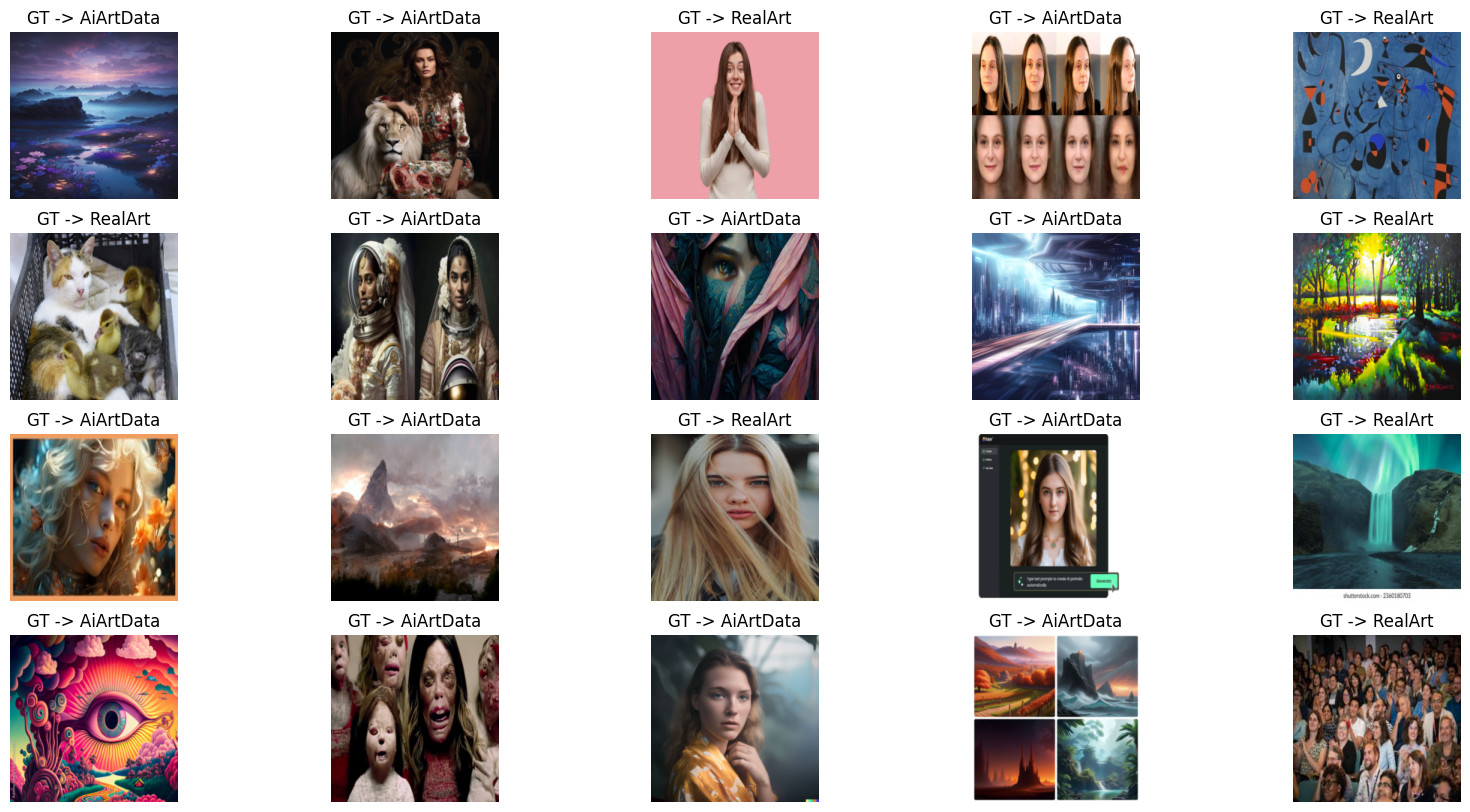

In [6]:

from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

In [24]:
# visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))

In [25]:
# visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

/var/folders/c7/l63jm69145b4rgctpltxy_7m0000gn/T/ipykernel_6979/1844673426.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation = 60)


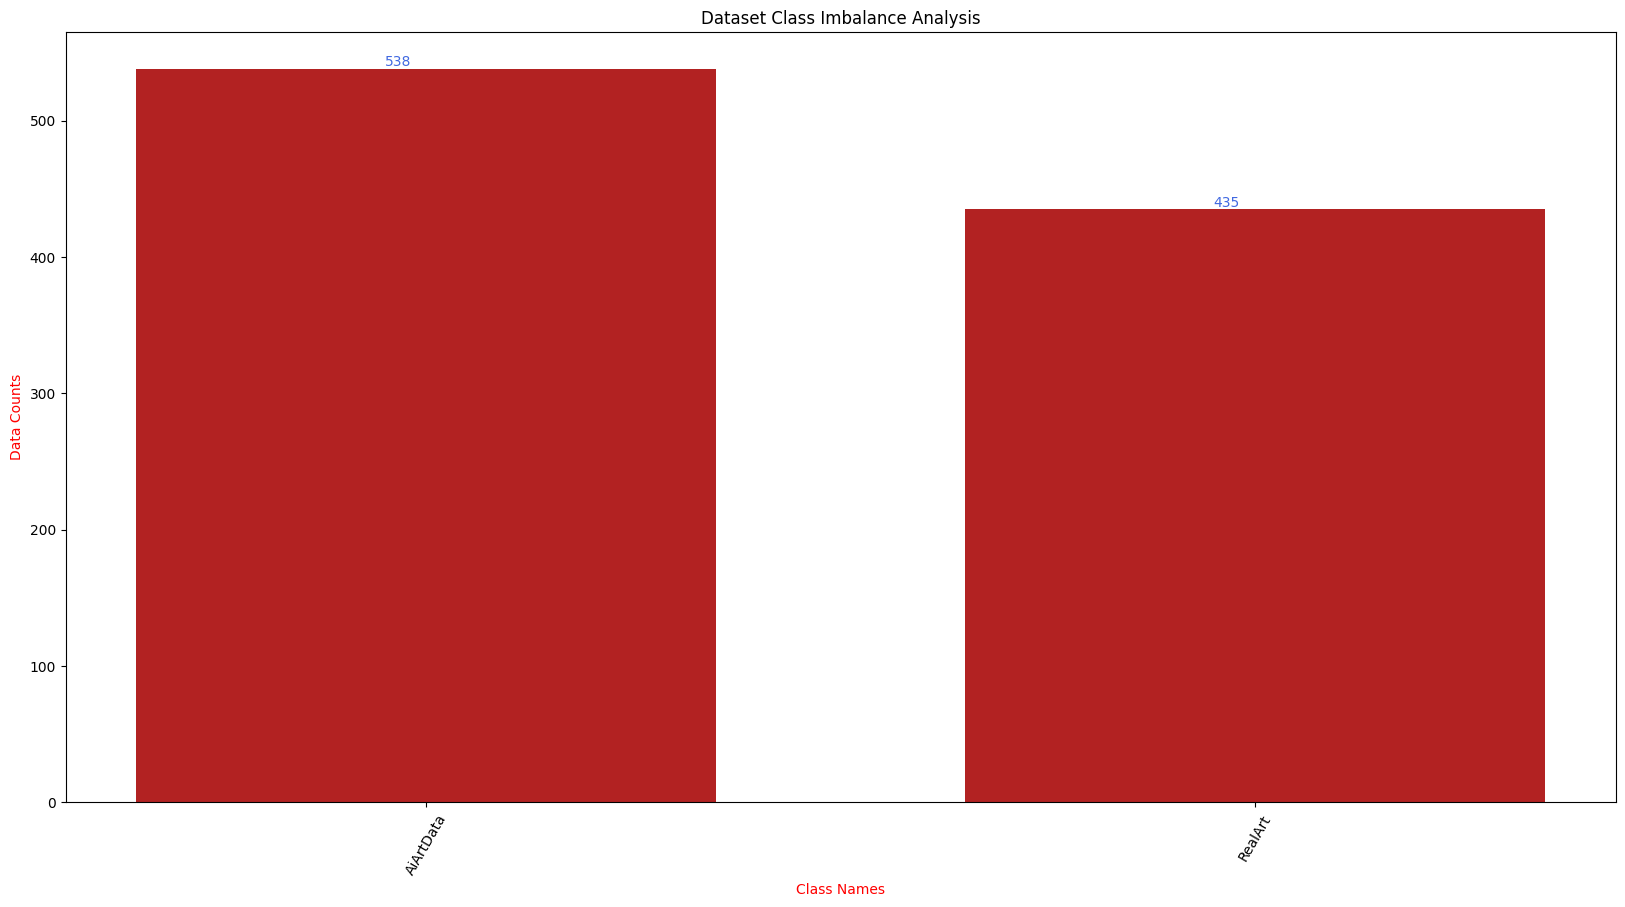

In [7]:
def data_analysis(root, transformations):
    
    ds = CustomDataset(root = root, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())
    
    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")
    
data_analysis(root = root, transformations = tfs)

## Train your model
I have used a pretrained image model (rexnet_150) then **finetuning** it over the custom data set. <br>
You can **skip** the training and validation part, and use the already trained saved model in repo (AI_best_model.pth)

1


In [14]:
#training
import timm, torchmetrics
from tqdm import tqdm
m = timm.create_model("rexnet_150", pretrained = True, num_classes = len(classes))  

def train_setup(m): return m.to("cpu").eval(), 10, "cpu", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 3e-4)
def to_device(batch, device): return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item(), epoch_f1 + f1_score(preds, gts)

m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = len(classes)).to(device)
save_prefix, save_dir = "AI", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)
    
for epoch in range(epochs):

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc  / len(tr_dl.dataset)
    tr_f1_to_track   = epoch_f1   / len(tr_dl)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track); tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1)

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc  / len(val_dl.dataset)
        val_f1_to_track   = val_epoch_f1   / len(val_dl)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track); val_f1s.append(val_f1_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")
            
        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

Start training...


0it [00:04, ?it/s]


KeyboardInterrupt: 

## Check training and validation loses

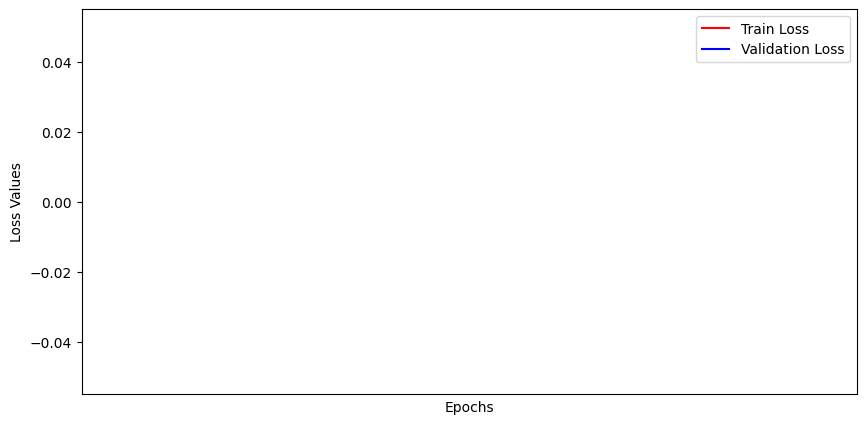

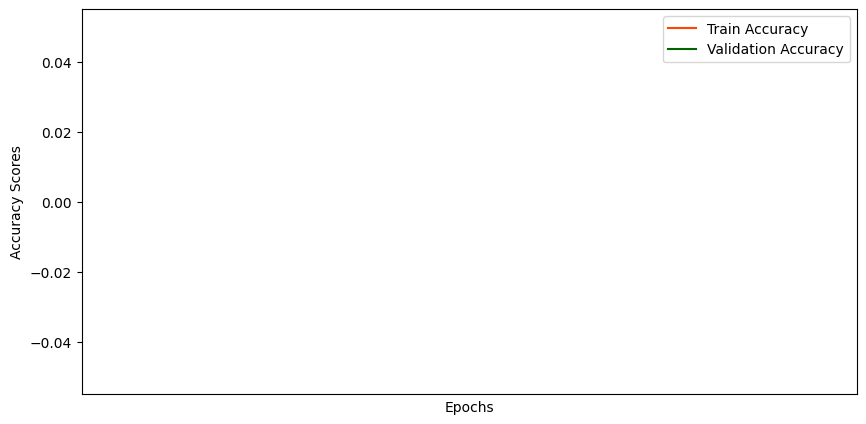

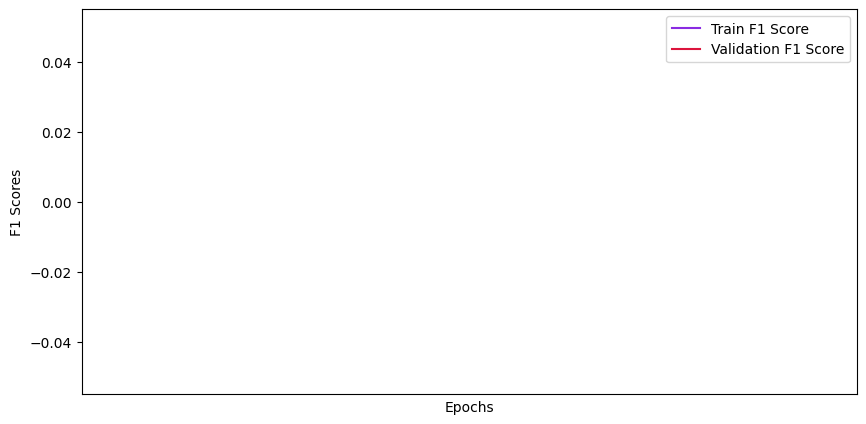

In [29]:
class PlotLearningCurves:
    
    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):
        
        self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s = tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s
        
    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):
        
        plt.plot(array_1, label = label_1, c = color_1); plt.plot(array_2, label = label_2, c = color_2)
        
    def create_figure(self): plt.figure(figsize = (10, 5))
    
    def decorate(self, ylabel, xlabel = "Epochs"): 
        
        plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.tr_accs)), labels = [i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend(); plt.show()      
        
    def visualize(self):
        
        # Figure 1
        self.create_figure()
        self.plot(array_1 = self.tr_losses, array_2 = self.val_losses, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = "red", color_2 = "blue"); self.decorate(ylabel = "Loss Values")
        
        # Figure 2
        self.create_figure()
        self.plot(array_1 = self.tr_accs, array_2 = self.val_accs, label_1 = "Train Accuracy", label_2 = "Validation Accuracy", color_1 = "orangered", color_2 = "darkgreen")
        self.decorate(ylabel = "Accuracy Scores")
        
        # Figure 3
        self.create_figure()
        self.plot(array_1 = [tr_f1.cpu() for tr_f1 in self.tr_f1s], array_2 = [vl_f1.cpu() for vl_f1 in self.val_f1s], label_1 = "Train F1 Score", label_2 = "Validation F1 Score", color_1 = "blueviolet", color_2 = "crimson"); self.decorate(ylabel = "F1 Scores")
        
PlotLearningCurves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s).visualize()

## Testing the model
The best accuracy we could reach up to is **83.0%**

/var/folders/c7/l63jm69145b4rgctpltxy_7m0000gn/T/ipykernel_6979/2451140900.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load(f"AI_best_model.

Accuracy of the model on the test data -> 0.83


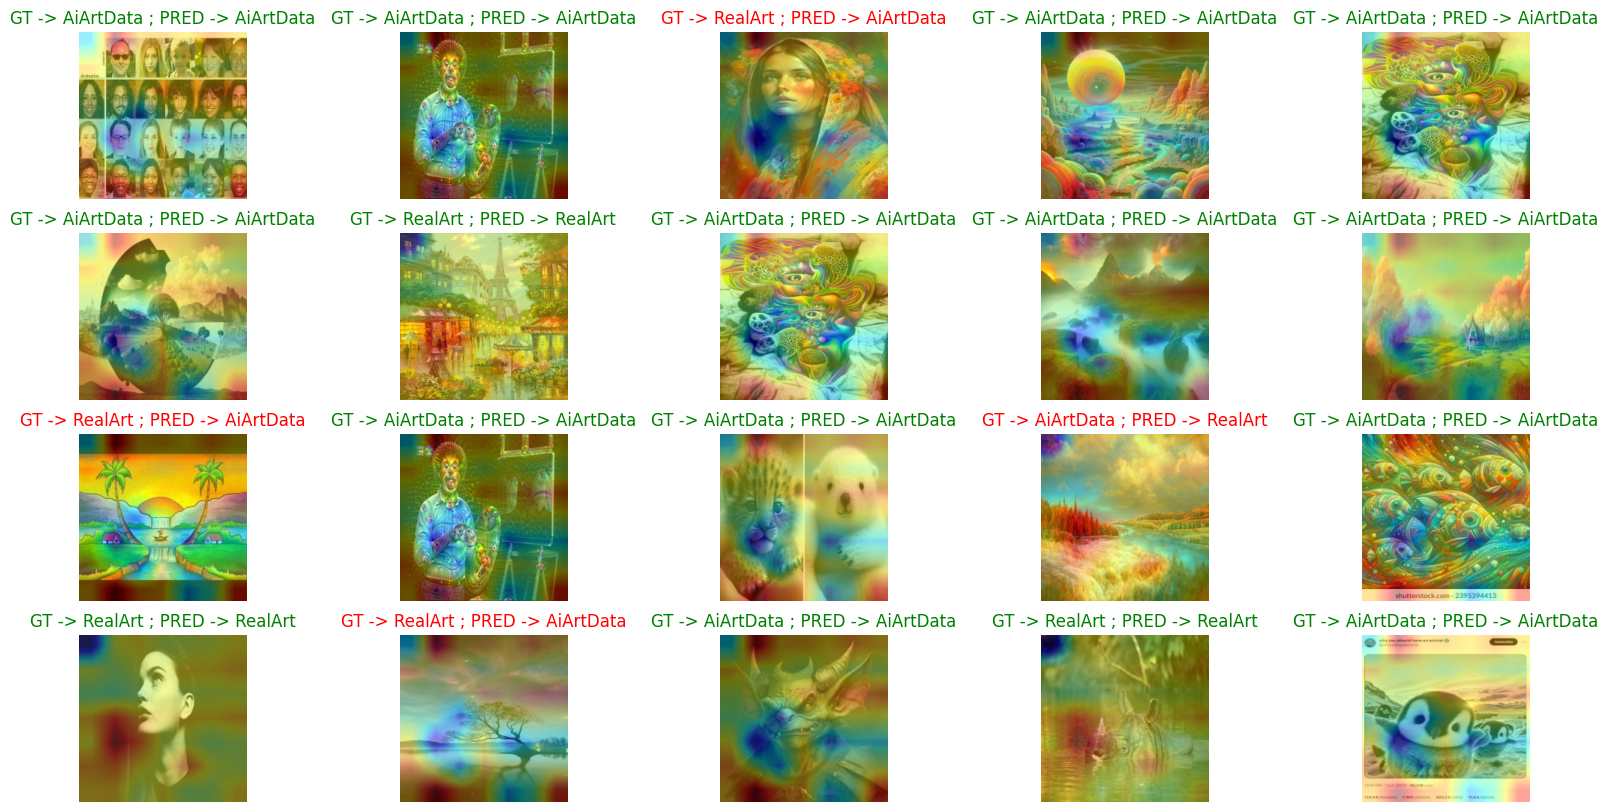

In [21]:
import cv2
class SaveFeatures():
    
    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

def getCAM(conv_fs, linear_weights, class_idx):
    
    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0,:, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)
    
    return (cam - np.min(cam)) / np.max(cam)

def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names = None):
    
    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        im, gt = to_device(batch, device)
        pred_class = torch.argmax(model(im), dim = 1)
        acc += (pred_class == gt).sum().item()
        images.append(im)
        preds.append(pred_class.item())
        lbls.append(gt.item())
    
    print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
    
    for idx, indeks in enumerate(indekslar):
        
        im = images[indeks].squeeze()
        pred_idx = preds[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)
        
        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap = "gray"); plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (im_size, im_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet'); plt.axis("off")
        
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {pred}")
device = "cpu"
m.load_state_dict(torch.load(f"AI_best_model.pth", map_location=torch.device('cpu')))
m.eval()
final_conv, fc_params = m.features[-1], list(m.head.fc.parameters())
inference(model = m.to(device), device = device, test_dl = ts_dl, num_ims = 20, row = 4, cls_names = list(classes.keys()), final_conv = final_conv, fc_params = fc_params)

## Use our custom images to classify

IndexError: index 3 is out of bounds for axis 0 with size 3

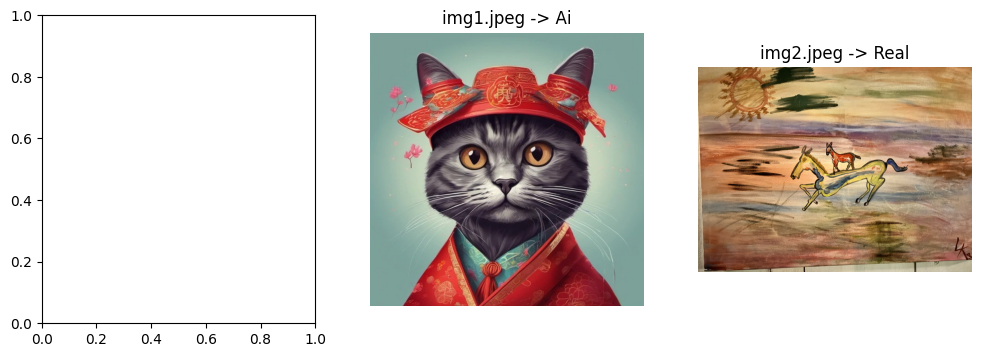

In [30]:
from PIL import Image

# {'AiArtData': 0, 'RealArt': 1}

def load_image(img_path):
    image = Image.open(img_path)
    image = tfs(image)
    image = image.unsqueeze(0)
    return image
    
image_paths = ["img1.jpeg","img2.jpeg","img3.jpeg"]

images = [(load_image(img_path),img_path) for img_path in image_paths]

m.eval()

with torch.no_grad():
    indx = 0
    fig, axes = plt.subplots(1, len(image_paths), figsize=(12, 4))
    for image,path in images:
        indx+=1
        output = m(image)
        _, predicted = torch.max(output,1)
        imgg = Image.open(path)
        
        # Resize the image
        # imgg = imgg.resize((200, 200))  # Resize to 200x200 pixels
        
        axes[indx].imshow(imgg)
        axes[indx].set_title(f"{path} -> { "Real" if predicted.item() else "Ai"}")
        axes[indx].axis('off')
        
        
        # print(f"{path}:  { "Real" if predicted.item() else "Ai"} , {predicted.item()}")

plt.tight_layout()
plt.show()